# MO10 DBT Model Report
## Data Collection Pipeline Overview

**Student:** Nicolas Edier  
**Database:** DS2508  
**Schema:** NNU7HU

## Data Collection Process

I collected stock market "gainers" data from two sources:

1. **Yahoo Finance** - Daily top gainers from finance.yahoo.com
2. **Wall Street Journal** - Daily top movers from wsj.com

The data is collected **three times per day** (1:30 PM, 5:00 PM, and 8:30 PM EST) on weekdays using automated cron jobs that run headless Chrome browser to scrape the data.

### Tables in Snowflake:

- **Database:** DS2508
- **Schema:** NNU7HU
- **Source Tables:** 
  - `YGAINERS_YYYYMMDD_HHMMSS` (multiple timestamped tables from Yahoo Finance)
  - `WSJGAINERS_YYYYMMDD_HHMMSS` (multiple timestamped tables from WSJ)
  
Each timestamp represents a data collection event.

## Entity Relationship Diagram
```
┌──────────────────────────────┐
│  YGAINERS_* (15 tables)      │
│  - Contains: symbol, price,  │
│    change, volume, etc.      │
└──────────────┬───────────────┘
               │
               │  Many symbols from
               │  multiple snapshots
               │
               ▼
        ┌─────────────────┐
        │  UNIQUE_SYMS    │
        │  (DISTINCT)     │
        │  - symbol       │
        └─────────────────┘
               ▲
               │
               │  Many symbols from
               │  multiple snapshots
               │
┌──────────────┴───────────────┐
│  WSJGAINERS_* (8 tables)     │
│  - Contains: company name    │
│    (with symbol in parens)   │
└──────────────────────────────┘
```

**Relationship:** Many-to-One  
The model extracts all unique stock symbols that have appeared across all timestamped gainer tables from both sources.

## DBT Model

**GitHub Link:**  
`https://github.com/NicolasEdier/2508_DS5111_nnu7hu/blob/mo10_dbt_model/
my_dbt_project/myfirstproject/models/example/unique_syms.sql`

### SQL Code:
```sql
SELECT 
    symbol,
    COUNT(*) as occurrence_count
FROM (
    -- Yahoo Finance Gainers
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251013_143026
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251013_170014
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251013_203021
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251014_133020
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251014_170014
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251014_203018
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251015_133025
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251015_170016
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251015_203018
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251016_133020
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251016_170018
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251016_203014
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251017_133013
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251017_170015
    UNION ALL
    SELECT symbol FROM DS2508.NNU7HU.YGAINERS_20251017_203014
    
    -- Wall Street Journal Gainers
    UNION ALL
    SELECT REGEXP_SUBSTR(COMPANY, '\\(([A-Z]+)\\)', 1, 1, 'e') as symbol 
    FROM DS2508.NNU7HU.WSJGAINERS_20251013_143026
    UNION ALL
    SELECT REGEXP_SUBSTR(COMPANY, '\\(([A-Z]+)\\)', 1, 1, 'e') as symbol 
    FROM DS2508.NNU7HU.WSJGAINERS_20251013_203021
    UNION ALL
    SELECT REGEXP_SUBSTR(COMPANY, '\\(([A-Z]+)\\)', 1, 1, 'e') as symbol 
    FROM DS2508.NNU7HU.WSJGAINERS_20251014_133020
    UNION ALL
    SELECT REGEXP_SUBSTR(COMPANY, '\\(([A-Z]+)\\)', 1, 1, 'e') as symbol 
    FROM DS2508.NNU7HU.WSJGAINERS_20251014_203018
    UNION ALL
    SELECT REGEXP_SUBSTR(COMPANY, '\\(([A-Z]+)\\)', 1, 1, 'e') as symbol 
    FROM DS2508.NNU7HU.WSJGAINERS_20251015_133025
    UNION ALL
    SELECT REGEXP_SUBSTR(COMPANY, '\\(([A-Z]+)\\)', 1, 1, 'e') as symbol 
    FROM DS2508.NNU7HU.WSJGAINERS_20251016_133020
    UNION ALL
    SELECT REGEXP_SUBSTR(COMPANY, '\\(([A-Z]+)\\)', 1, 1, 'e') as symbol 
    FROM DS2508.NNU7HU.WSJGAINERS_20251017_170015
    UNION ALL
    SELECT REGEXP_SUBSTR(COMPANY, '\\(([A-Z]+)\\)', 1, 1, 'e') as symbol 
    FROM DS2508.NNU7HU.WSJGAINERS_20251017_203014
)
WHERE symbol IS NOT NULL AND symbol != ''
GROUP BY symbol
ORDER BY occurrence_count DESC, symbol
```

**Note:** The WSJ data stores symbols within company names like "Company Name (SYMBOL)", requiring regex extraction.

## Result Table Path

**Full Path:** `DS2508.NNU7HU.UNIQUE_SYMS`

Top 10 Most Frequent Gainers:
  SYMBOL  OCCURRENCE_COUNT
0   FLNC                16
1   NVTS                16
2   CRML                14
3    EXK                12
4   QBTS                12
5   BITF                11
6    SMR                11
7   SNDK                11
8     AG                10
9    ASX                10


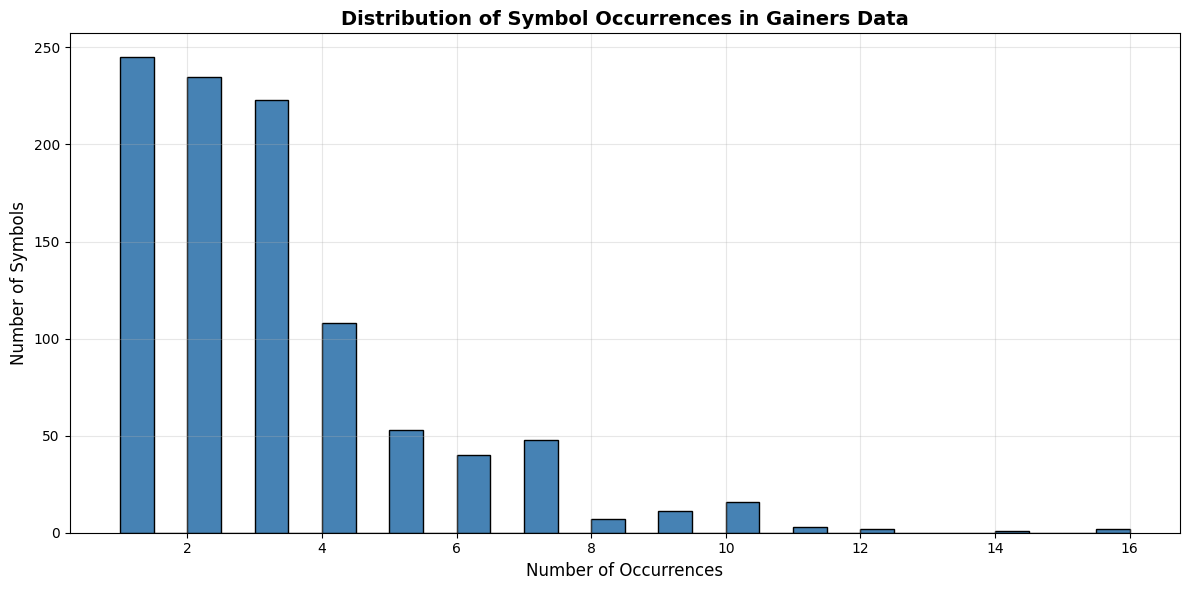


Symbol with most occurrences: FLNC (16 times)
Total unique symbols: 994


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df_counts = pd.read_csv('unique_sym.csv')

# Top 10 Counts
print("Top 10 Most Frequent Gainers:")
print(df_counts.head(10))

# Histogram
plt.figure(figsize=(12, 6))
plt.hist(df_counts['OCCURRENCE_COUNT'], bins=30, edgecolor='black', color='steelblue')
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Number of Symbols', fontsize=12)
plt.title('Distribution of Symbol Occurrences in Gainers Data', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nSymbol with most occurrences: {df_counts.iloc[0]['SYMBOL']} ({df_counts.iloc[0]['OCCURRENCE_COUNT']} times)")
print(f"Total unique symbols: {len(df_counts)}")